In [1]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 18.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.w

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

##Load the CIFAR-10 dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

batch_size=10;


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13708315.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


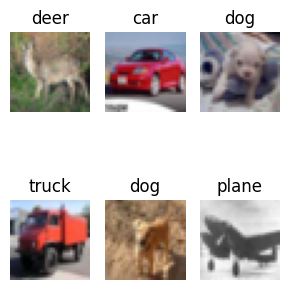

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the figure size
plt.figure(figsize=(3, 4))  # 6 columns and 4 rows

# Show images and print labels for the first 6 images
for i in range(batch_size):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## Define the model architecture

In [5]:
import torch
import torch.nn as nn

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

model.fc = nn.Linear(512, 10)  # Define new fully connected layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 74.3MB/s]


## Define a Loss function and optimizer.
Using a Classification Cross-Entropy loss and Adam with momentum.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
num_epochs = 5
for epoch in range(num_epochs): # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader: # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Loss: 2.3027, Train Accuracy: 0.1095, Val Accuracy: 0.1000
Epoch 2/5, Loss: 2.3086, Train Accuracy: 0.0991, Val Accuracy: 0.1000
Epoch 3/5, Loss: 2.3052, Train Accuracy: 0.0984, Val Accuracy: 0.1000
Epoch 4/5, Loss: 2.3040, Train Accuracy: 0.0999, Val Accuracy: 0.1000
Epoch 5/5, Loss: 2.3036, Train Accuracy: 0.0970, Val Accuracy: 0.1000


##Saving our trained model

In [8]:
torch.save(model.state_dict(), 'cifar10_model.pth')

##Test the network on the test data
We have trained the network for 5 epoch over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

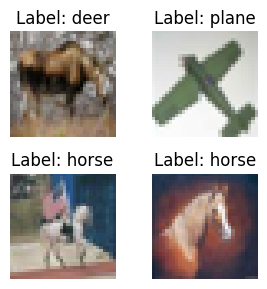

In [9]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
# Define the figure size
plt.figure(figsize=(3, 3))  # 3 columns and 4 rows

# Print images and labels for the first 4 images
for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


##Load the pre trained model

In [10]:
model.load_state_dict(torch.load('cifar10_model.pth'))

<All keys matched successfully>

In [11]:
# Assuming 'images' is your input tensor and 'model' is your neural network model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the same device as the input tensor
model = model.to(device)

# Move the input tensor to the same device as the model
images = images.to(device)

# Now perform the forward pass
outputs = model(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  car   car   car   car  


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        # Move the model to the same device as the input tensor
        model = model.to(device)

        # Move the input tensor to the same device as the model
        images = images.to(device)

        # Now perform the forward pass
        outputs = model(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        # Assuming 'labels' is your tensor containing the ground truth labels
        labels = labels.to(device)

        # Now you can perform the operation
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # Move the model to the device
        model = model.to(device)

        # Move the input tensor to the same device as the model
        images = images.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    if classname in total_pred and total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'No predictions made or no test samples for class: {classname}')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 100.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


# TPGD attack

Original Label: 9
The image has not been attacked by an adversarial perturbation.


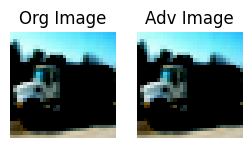

Original Prediction: car
Adversarial Prediction: car
Success Rate: 0.0


In [16]:
# Define the TPGD attack
attack_TPGD = torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=10)

# Choose a random data point from the test dataset
index_TPGD = np.random.randint(0, len(test_dataset))
original_image_TPGD, original_label_TPGD = test_dataset[index_TPGD]
print("Original Label:", original_label_TPGD)

# Ensure original_label is a PyTorch tensor
original_label_tensor_TPGD = torch.tensor(original_label_TPGD)

# Apply the TPGD attack to the original image
adv_images_TPGD = attack_TPGD(original_image_TPGD.unsqueeze(0).cuda(), original_label_tensor_TPGD.unsqueeze(0).cuda())

# Predictions on original and adversarial images
original_prediction_TPGD = torch.argmax(model(original_image_TPGD.unsqueeze(0).cuda()))
adversarial_prediction_TPGD = torch.argmax(model(adv_images_TPGD))

# Check if the predictions differ
if original_prediction_TPGD != adversarial_prediction_TPGD:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_TPGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_TPGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_TPGD.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_TPGD.item()])

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_TPGD != adversarial_prediction_TPGD:
    successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##MIFGSM attack

Original Label: 8
The image has not been attacked by an adversarial perturbation.


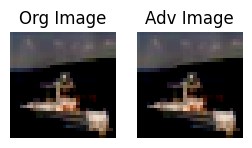

Original Prediction: car
Adversarial Prediction: car
Success Rate: 0.0


In [19]:
# Choose a random data point from the test dataset
index_MIFGSM = np.random.randint(0, len(test_dataset))
original_image_MIFGSM, original_label_MIFGSM = test_dataset[index_MIFGSM]
print("Original Label:", original_label_MIFGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_MIFGSM = torch.tensor(original_label_MIFGSM).to(device)

# Apply the MIFGSM attack to the original image
attack_MIFGSM = torchattacks.MIFGSM(model, eps=8/255, steps=10, decay=1.0)
adv_images_MIFGSM = attack_MIFGSM(original_image_MIFGSM.unsqueeze(0).to(device), original_label_tensor_MIFGSM.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_MIFGSM = torch.argmax(model(original_image_MIFGSM.unsqueeze(0).to(device)))
adversarial_prediction_MIFGSM = torch.argmax(model(adv_images_MIFGSM))

# Check if the predictions differ
if original_prediction_MIFGSM != adversarial_prediction_MIFGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_MIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_MIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_MIFGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_MIFGSM.item()])

# Check if the predictions differ
# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_MIFGSM != adversarial_prediction_MIFGSM:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##TIFGSM attack

Original Label: 4
The image has not been attacked by an adversarial perturbation.


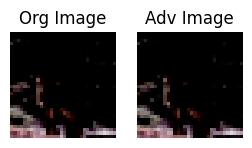

Original Prediction: car
Adversarial Prediction: car
Success Rate: 0.0


In [20]:
# Define the TIFGSM attack
attack_TIFGSM = torchattacks.TIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, resize_rate=0.9, diversity_prob=0.7, random_start=False)

# Choose a random data point from the test dataset
index_TIFGSM = np.random.randint(0, len(test_dataset))
original_image_TIFGSM, original_label_TIFGSM = test_dataset[index_TIFGSM]
print("Original Label:", original_label_TIFGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_TIFGSM = torch.tensor(original_label_TIFGSM)

# Apply the TIFGSM attack to the original image
adv_images_TIFGSM = attack_TIFGSM(original_image_TIFGSM.unsqueeze(0).cuda(), original_label_tensor_TIFGSM.unsqueeze(0).cuda())

# Predictions on original and adversarial images
original_prediction_TIFGSM = torch.argmax(model(original_image_TIFGSM.unsqueeze(0).cuda()))
adversarial_prediction_TIFGSM = torch.argmax(model(adv_images_TIFGSM))

# Check if the predictions differ
if original_prediction_TIFGSM != adversarial_prediction_TIFGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_TIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_TIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_TIFGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_TIFGSM.item()])

# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_TIFGSM != adversarial_prediction_TIFGSM:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##Jitter attack

Original Label: 6


The image has not been attacked by an adversarial perturbation.


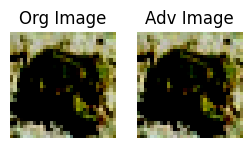

Original Prediction: car
Adversarial Prediction: car
Success Rate: 0.0


In [21]:
# Define the Jitter attack
attack_Jitter = torchattacks.Jitter(model, eps=8/255, alpha=2/255, steps=10,
                                    scale=10, std=0.1, random_start=True)

# Choose a random data point from the test dataset
index_Jitter = np.random.randint(0, len(test_dataset))
original_image_Jitter, original_label_Jitter = test_dataset[index_Jitter]
print("Original Label:", original_label_Jitter)

# Ensure original_label is a PyTorch tensor
original_label_tensor_Jitter = torch.tensor(original_label_Jitter)

# Apply the Jitter attack to the original image
adv_images_Jitter = attack_Jitter(original_image_Jitter.unsqueeze(0).cuda(), original_label_tensor_Jitter.unsqueeze(0).cuda())

# Predictions on original and adversarial images
original_prediction_Jitter = torch.argmax(model(original_image_Jitter.unsqueeze(0).cuda()))
adversarial_prediction_Jitter = torch.argmax(model(adv_images_Jitter))

# Check if the predictions differ
if original_prediction_Jitter != adversarial_prediction_Jitter:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_Jitter.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_Jitter.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_Jitter.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_Jitter.item()])

# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_Jitter != adversarial_prediction_Jitter:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##NIFGSM attacks

Original Label: 0
The image has not been attacked by an adversarial perturbation.


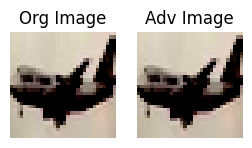

Original Prediction: car
Adversarial Prediction: car
Success Rate: 0.0


In [22]:
# Define the NIFGSM attack
attack_NIFGSM = torchattacks.NIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0)

# Choose a random data point from the test dataset
index_NIFGSM = np.random.randint(0, len(test_dataset))
original_image_NIFGSM, original_label_NIFGSM = test_dataset[index_NIFGSM]
print("Original Label:", original_label_NIFGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_NIFGSM = torch.tensor(original_label_NIFGSM)

# Apply the NIFGSM attack to the original image
adv_images_NIFGSM = attack_NIFGSM(original_image_NIFGSM.unsqueeze(0).cuda(), original_label_tensor_NIFGSM.unsqueeze(0).cuda())

# Predictions on original and adversarial images
original_prediction_NIFGSM = torch.argmax(model(original_image_NIFGSM.unsqueeze(0).cuda()))
adversarial_prediction_NIFGSM = torch.argmax(model(adv_images_NIFGSM))

# Check if the predictions differ
if original_prediction_NIFGSM != adversarial_prediction_NIFGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_NIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_NIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_NIFGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_NIFGSM.item()])

# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_NIFGSM != adversarial_prediction_NIFGSM:
    successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##Comparing all attacks

In [ ]:
# Define the TPGD attack
attack_TPGD = torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=10)
# Define the MIFGSM attack
attack_MIFGSM = torchattacks.MIFGSM(model, eps=8/255, steps=10, decay=1.0)
# Define the TIFGSM attack
attack_TIFGSM = torchattacks.TIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, resize_rate=0.9, diversity_prob=0.7, random_start=False)
# Define the Jitter attack
attack_Jitter = torchattacks.Jitter(model, eps=8/255, alpha=2/255, steps=10, scale=10, std=0.1, random_start=True)
# Define the NIFGSM attack
attack_NIFGSM = torchattacks.NIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize variables to count successful attacks
successful_attacks_TPGD = 0
successful_attacks_MIFGSM = 0
successful_attacks_TIFGSM = 0
successful_attacks_Jitter = 0
successful_attacks_NIFGSM = 0

total_samples = len(test_dataset)

# Iterate over the test dataset
for original_image, original_label in test_dataset:
    # Ensure original_label is a PyTorch tensor
    original_label_tensor = torch.tensor(original_label)
    original_image = original_image.to(device)

    # Apply the TPGD attack to the original image
    adv_images_TPGD = attack_TPGD(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the MIFGSM attack to the original image
    adv_images_MIFGSM = attack_MIFGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the TIFGSM attack to the original image
    adv_images_TIFGSM = attack_TIFGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the Jitter attack to the original image
    adv_images_Jitter = attack_Jitter(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the NIFGSM attack to the original image
    adv_images_NIFGSM = attack_NIFGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))

    # Predictions on original and adversarial images
    original_prediction = torch.argmax(model(original_image.unsqueeze(0)))
    adversarial_prediction_TPGD = torch.argmax(model(adv_images_TPGD))
    adversarial_prediction_MIFGSM = torch.argmax(model(adv_images_MIFGSM))
    adversarial_prediction_TIFGSM = torch.argmax(model(adv_images_TIFGSM))
    adversarial_prediction_Jitter = torch.argmax(model(adv_images_Jitter))
    adversarial_prediction_NIFGSM = torch.argmax(model(adv_images_NIFGSM))

    # Check if the predictions differ for TPGD attack
    if original_prediction != adversarial_prediction_TPGD:
        successful_attacks_TPGD += 1

    # Check if the predictions differ for MIFGSM attack
    if original_prediction != adversarial_prediction_MIFGSM:
        successful_attacks_MIFGSM += 1

    # Check if the predictions differ for TIFGSM attack
    if original_prediction != adversarial_prediction_TIFGSM:
        successful_attacks_TIFGSM += 1

    # Check if the predictions differ for Jitter attack
    if original_prediction != adversarial_prediction_Jitter:
        successful_attacks_Jitter += 1

    # Check if the predictions differ for NIFGSM attack
    if original_prediction != adversarial_prediction_NIFGSM:
        successful_attacks_NIFGSM += 1

# Calculate the success rate for each attack
success_rate_TPGD = successful_attacks_TPGD / total_samples
success_rate_MIFGSM = successful_attacks_MIFGSM / total_samples
success_rate_TIFGSM = successful_attacks_TIFGSM / total_samples
success_rate_Jitter = successful_attacks_Jitter / total_samples
success_rate_NIFGSM = successful_attacks_NIFGSM / total_samples

# Print the success rates for each attack
print("TPGD Success Rate:", success_rate_TPGD)
print("MIFGSM Success Rate:", success_rate_MIFGSM)
print("TIFGSM Success Rate:", success_rate_TIFGSM)
print("Jitter Success Rate:", success_rate_Jitter)
print("NIFGSM Success Rate:", success_rate_NIFGSM)

# Compare which attack has the highest success rate
highest_success_rate = max(success_rate_TPGD, success_rate_MIFGSM, success_rate_TIFGSM, success_rate_Jitter, success_rate_NIFGSM)
if highest_success_rate == success_rate_TPGD:
    print("TPGD has the highest success rate.")
elif highest_success_rate == success_rate_MIFGSM:
    print("MIFGSM has the highest success rate.")
elif highest_success_rate == success_rate_TIFGSM:
    print("TIFGSM has the highest success rate.")
elif highest_success_rate == success_rate_Jitter:
    print("Jitter has the highest success rate.")
else:
    print("NIFGSM has the highest success rate.")

TPGD Success Rate: 0.0
MIFGSM Success Rate: 0.0
TIFGSM Success Rate: 0.0
Jitter Success Rate: 0.0
NIFGSM Success Rate: 0.0
TPGD has the highest success rate.
